In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

## Load dataset

In [2]:
X_train = np.load('datasets/X_train.npy')
y_train = np.load('datasets/y_train.npy')
X_val = np.load('datasets/X_val.npy')
y_val = np.load('datasets/y_val.npy')

In [3]:
# Print shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (1587, 100, 9)
X_val shape: (397, 100, 9)
y_train shape: (1587,)
y_val shape: (397,)


In [4]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Adjust weight for positive class (e.g., reduce by 25%)
class_weight_dict[1] = class_weight_dict[1] * 0.75
print("Adjusted class weights:", class_weight_dict)

Adjusted class weights: {0: 0.5272425249169436, 1: 7.257621951219512}


## LSTM

In [8]:
# LSTM 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Input, Dropout

max_len = 100
n_features = 9

lstm_model = Sequential([
    Input(shape=(max_len, n_features)),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.summary()

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
lstm_model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=10, 
    batch_size=32,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7590 - loss: 0.5464 - precision: 0.1536 - recall: 0.7676 - val_accuracy: 0.7280 - val_loss: 0.4429 - val_precision: 0.1520 - val_recall: 0.9048
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7416 - loss: 0.3842 - precision: 0.1432 - recall: 0.8956 - val_accuracy: 0.7305 - val_loss: 0.4148 - val_precision: 0.1532 - val_recall: 0.9048
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7293 - loss: 0.4384 - precision: 0.1765 - recall: 0.8913 - val_accuracy: 0.7305 - val_loss: 0.3505 - val_precision: 0.1532 - val_recall: 0.9048
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7589 - loss: 0.3713 - precision: 0.1653 - recall: 0.8993 - val_accuracy: 0.7431 - val_loss: 0.3656 - val_precision: 0.1597 - val_recall: 0.9048
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7410 - loss: 0.4017 - precision: 0.1691 - recall: 0.9366 - val_accuracy: 0.7582 - val_loss: 0.3779 

### LSTM - Hyperparameter Tuning

In [10]:
# Define the model-building function for KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

max_len = 100
n_features = 9


def create_lstm_model(dropout_rate=0.2, learning_rate=0.001):
    max_len = 100
    n_features = 9
    model = Sequential([
        Input(shape=(max_len, n_features)),
        LSTM(64, return_sequences=False),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])
    return model

In [11]:
# Hyperparameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0005, 0.0001]
}

# Store results
results = []

In [12]:
# Manual grid search
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

for dropout_rate in param_grid['dropout_rate']:
    for learning_rate in param_grid['learning_rate']:
        print(f"\nTesting: dropout_rate={dropout_rate}, learning_rate={learning_rate}")
            
        # Create and train model
        model = create_lstm_model(dropout_rate=dropout_rate, learning_rate=learning_rate)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=32,
            verbose=1,
            class_weight=class_weight_dict,
            callbacks=[early_stopping]
        )
            
        # Evaluate on validation set
        y_pred_prob = model.predict(X_val).flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)
            
        auc_roc = roc_auc_score(y_val, y_pred_prob)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
            
        # Store results
        results.append({
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'auc_roc': auc_roc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
            
        print(f"AUC-ROC: {auc_roc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


Testing: dropout_rate=0.2, learning_rate=0.001
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8135 - loss: 0.5382 - precision: 0.1307 - recall: 0.5004 - val_accuracy: 0.7305 - val_loss: 0.3923 - val_precision: 0.1532 - val_recall: 0.9048
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7411 - loss: 0.4022 - precision: 0.1708 - recall: 0.9236 - val_accuracy: 0.7305 - val_loss: 0.3764 - val_precision: 0.1532 - val_recall: 0.9048
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7425 - loss: 0.3652 - precision: 0.1487 - recall: 0.9267 - val_accuracy: 0.7305 - val_loss: 0.3797 - val_precision: 0.1532 - val_recall: 0.9048
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7470 - loss: 0.3504 - precision: 0.1700 - recall: 0.9467 - val_accuracy: 0.7305 - val_loss: 0.3729 - val_precision: 0.1532 - val_recall: 0.9048
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7616 - loss: 0.3744 - precision: 0.1704 - recall: 0

In [13]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df)

# Find best model based on F1-score
best_result = results_df.loc[results_df['f1'].idxmax()]
print("\nBest Parameters:")
print(best_result)


All Results:
   dropout_rate  learning_rate   auc_roc  precision    recall        f1
0           0.2         0.0010  0.868604   0.186047  0.761905  0.299065
1           0.2         0.0005  0.805218   0.152000  0.904762  0.260274
2           0.2         0.0001  0.879813   0.153226  0.904762  0.262069
3           0.3         0.0010  0.846378   0.154472  0.904762  0.263889
4           0.3         0.0005  0.819022   0.152000  0.904762  0.260274
5           0.3         0.0001  0.824468   0.154472  0.904762  0.263889
6           0.4         0.0010  0.829914   0.152000  0.904762  0.260274
7           0.4         0.0005  0.853850   0.165217  0.904762  0.279412
8           0.4         0.0001  0.795339   0.153226  0.904762  0.262069

Best Parameters:
dropout_rate     0.200000
learning_rate    0.001000
auc_roc          0.868604
precision        0.186047
recall           0.761905
f1               0.299065
Name: 0, dtype: float64


In [41]:
# Train final model with best parameters
lstm_model = create_lstm_model(
    dropout_rate=best_result['dropout_rate'],
    learning_rate=best_result['learning_rate']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7467 - loss: 0.5216 - precision: 0.1326 - recall: 0.7161 - val_accuracy: 0.7305 - val_loss: 0.3799 - val_precision: 0.1532 - val_recall: 0.9048
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7377 - loss: 0.4327 - precision: 0.1553 - recall: 0.9216 - val_accuracy: 0.7305 - val_loss: 0.3659 - val_precision: 0.1532 - val_recall: 0.9048
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7377 - loss: 0.3363 - precision: 0.1218 - recall: 0.9149 - val_accuracy: 0.7305 - val_loss: 0.4108 - val_precision: 0.1532 - val_recall: 0.9048
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7224 - loss: 0.4373 - precision: 0.1487 - recall: 0.8788 - val_accuracy: 0.7305 - val_loss: 0.3789 - val_precision: 0.1532 - val_recall: 0.9048
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7321 - loss: 0.4130 - precision: 0.1763 - recall: 0.9412 - val_accuracy: 0.7305 - val_loss: 0.3686 

### LSTM - Evaluation 

In [42]:
# LSTM - Make predictions
y_pred_prob_lstm = lstm_model.predict(X_val)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int).flatten()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [43]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

# Compute evaluation metrics
auc_roc = roc_auc_score(y_val, y_pred_prob_lstm)
precision = precision_score(y_val, y_pred_lstm)
recall = recall_score(y_val, y_pred_lstm)
f1 = f1_score(y_val, y_pred_lstm)

# Print metrics
print("LSTM Models")
print("="*30)
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

LSTM Models
AUC-ROC: 0.8759
Precision: 0.1748
Recall: 0.8571
F1-Score: 0.2903


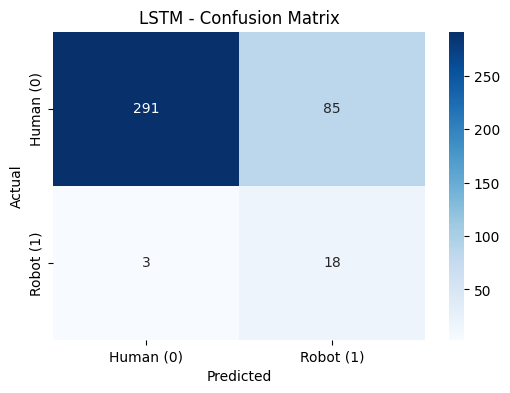

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# LSTM - Compute and plot confusion matrix
cm_lstm = confusion_matrix(y_val, y_pred_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Human (0)', 'Robot (1)'],
            yticklabels=['Human (0)', 'Robot (1)'])
plt.title('LSTM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

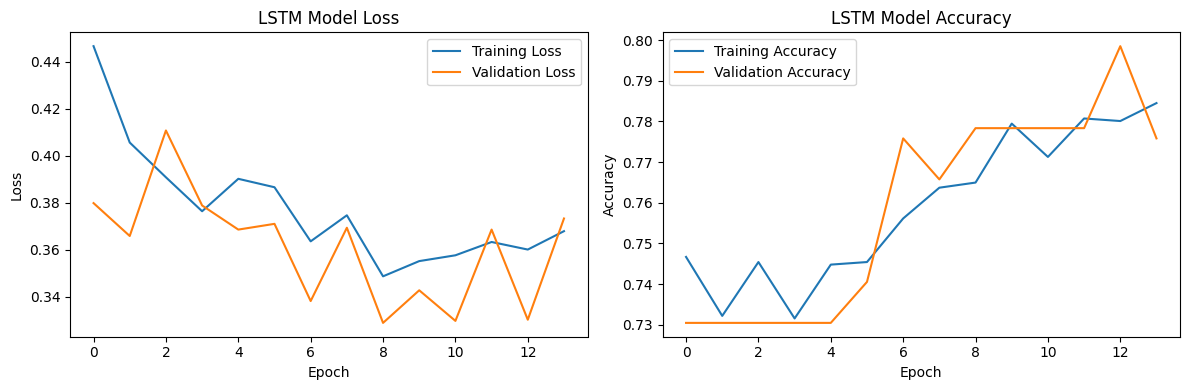

In [45]:
# Optional: LSTM - Plot training history (loss and accuracy)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
# Make predictions
y_train_pred_prob_lstm = lstm_model.predict(X_train)
y_test_pred_prob_lstm = lstm_model.predict(X_val)
y_train_pred_lstm = (y_train_pred_prob_lstm > 0.5).astype(int).flatten()
y_test_pred_lstm = (y_test_pred_prob_lstm > 0.5).astype(int).flatten()

# Compute evaluation metrics for training and test sets
metrics = {
    'AUC-ROC': [roc_auc_score(y_train, y_train_pred_prob_lstm), roc_auc_score(y_val, y_test_pred_prob_lstm)],
    'Precision': [precision_score(y_train, y_train_pred_lstm), precision_score(y_val, y_test_pred_lstm)],
    'Recall': [recall_score(y_train, y_train_pred_lstm), recall_score(y_val, y_test_pred_lstm)],
    'F1-Score': [f1_score(y_train, y_train_pred_lstm), f1_score(y_val, y_test_pred_lstm)]
}

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


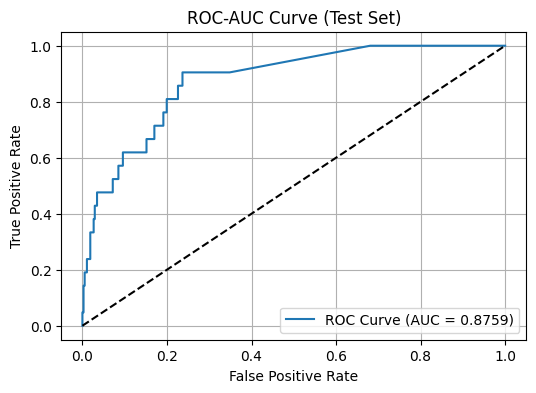

In [47]:
from sklearn.metrics import roc_curve, precision_recall_curve


# Plot ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob_lstm)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics["AUC-ROC"][1]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC-AUC Curve (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('findings/lstm_roc_auc_curve.png')
plt.show()
plt.close()

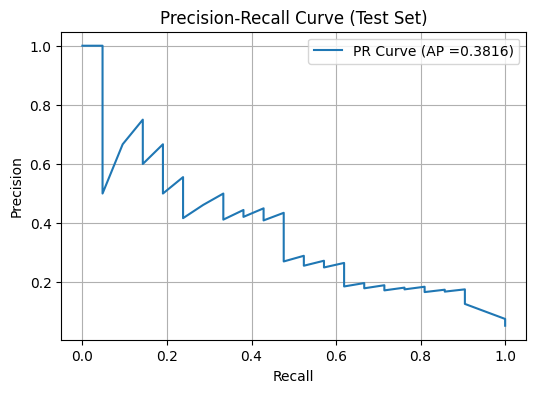

In [48]:
from sklearn.metrics import average_precision_score

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_test_pred_prob_lstm)
ap_score = average_precision_score(y_val, y_test_pred_prob_lstm)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR Curve (AP ={ap_score:.4f})')
plt.title('Precision-Recall Curve (Test Set)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.savefig('findings/lstm_precision_recall_curve.png')
plt.show()
plt.close()

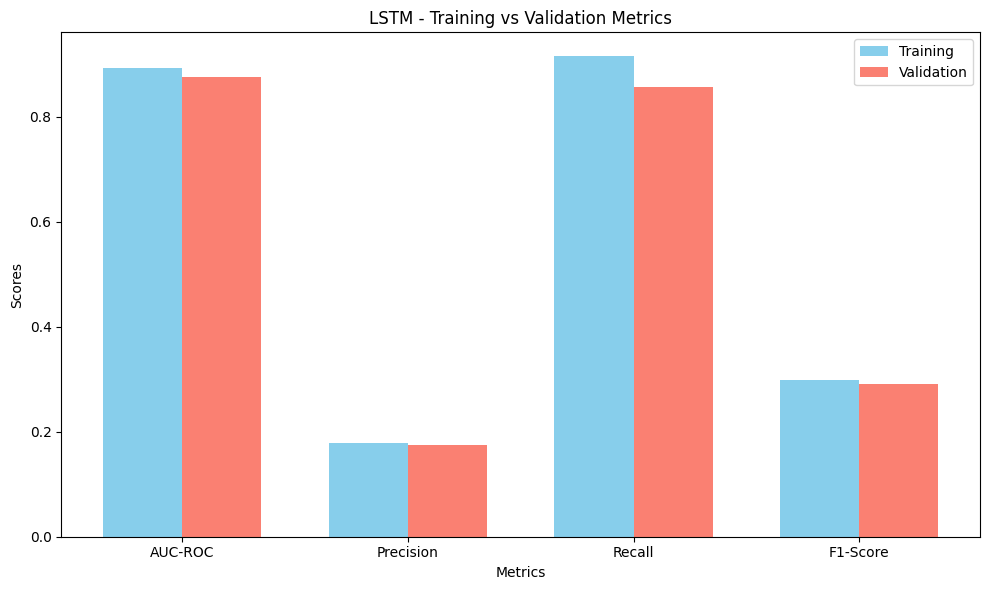

In [49]:
# Plot training vs validation bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics))

ax.bar(index, [metrics[m][0] for m in metrics], bar_width, label='Training', color='skyblue')
ax.bar(index + bar_width, [metrics[m][1] for m in metrics], bar_width, label='Validation', color='salmon')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('LSTM - Training vs Validation Metrics')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics.keys())
ax.legend()
plt.tight_layout()
plt.savefig('findings/lstm_training_vs_validation_metrics.png')
plt.show()
plt.close()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Threshold: 0.50, Precision: 0.175, Recall: 0.857, F1: 0.290
Threshold: 0.55, Precision: 0.173, Recall: 0.810, F1: 0.286
Threshold: 0.60, Precision: 0.176, Recall: 0.714, F1: 0.283
Threshold: 0.65, Precision: 0.189, Recall: 0.667, F1: 0.295
Threshold: 0.70, Precision: 0.312, Recall: 0.476, F1: 0.377
Threshold: 0.75, Precision: 0.500, Recall: 0.333, F1: 0.400
Threshold: 0.80, Precision: 0.600, Recall: 0.143, F1: 0.231
Threshold: 0.85, Precision: 0.750, Recall: 0.143, F1: 0.240


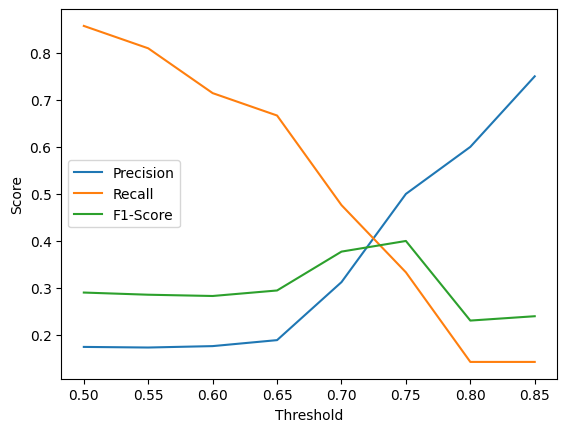

Optimal Threshold: 0.75
Final Precision: 0.500
Final Recall: 0.333
Final F1-Score: 0.400


In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_proba = lstm_model.predict(X_val)

# Evaluate different thresholds
thresholds = np.arange(0.5, 0.9, 0.05)
precisions, recalls, f1_scores = [], [], []
for thresh in thresholds:
    y_pred = (y_pred_proba > thresh).astype(int)
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))
    print(f"Threshold: {thresh:.2f}, Precision: {precisions[-1]:.3f}, Recall: {recalls[-1]:.3f}, F1: {f1_scores[-1]:.3f}")

# Plot precision-recall trade-off
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# Choose optimal threshold (e.g., maximizing F1 or precision with acceptable recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]  # Or manually select based on precision-recall balance
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Final Precision: {precision_score(y_val, y_pred_optimal):.3f}")
print(f"Final Recall: {recall_score(y_val, y_pred_optimal):.3f}")
print(f"Final F1-Score: {f1_score(y_val, y_pred_optimal):.3f}")

In [51]:
lstm_model.save('models/lstm_model.keras')

### Testing on Test set

In [107]:
X_test = np.load('datasets/X_test.npy')

In [108]:
X_test.shape

(4630, 100, 9)

In [109]:
# LSTM - Make predictions
y_pred_prob_lstm = lstm_model.predict(X_test)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int).flatten()

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [110]:
y_pred_prob_lstm.shape

(4630, 1)

In [111]:
y_pred_series = pd.Series(y_pred_prob_lstm.reshape(-1), name='prediction') 
y_pred_series

0       0.031980
1       0.031980
2       0.031980
3       0.031938
4       0.681184
          ...   
4625    0.031980
4626    0.759515
4627    0.675885
4628    0.031980
4629    0.671818
Name: prediction, Length: 4630, dtype: float32

In [112]:
bidder_ids = np.load('datasets/bidders_ids.npy')
df = pd.DataFrame(bidder_ids, columns=['bidder_id'])

In [113]:
df['prediction'] = y_pred_series

In [114]:
df.head()

,bidder_id,prediction
0,002d229ffb247009810828f648afc2ef593rb,0.031980
1,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.031980
2,00486a11dff552c4bd7696265724ff81yeo9v,0.031980
3,0051aef3fdeacdadba664b9b3b07e04e4coc6,0.031938
4,0053b78cde37c4384a20d2da9aa4272aym4pb,0.681184


In [115]:
# bidder ids with missing columns -- assumes to be human
na_bidders = pd.read_csv('datasets/bidder_ids_na.csv')
na_bidders.head()

,bidder_id
0,b24e3af20453813e821f5a22ff55e072tgton
1,65489e2734f03652a76bf139df96c479lopnf
2,3c465a8c5b93301383617e4c539c850aumt08
3,55a699bd3a83fe99db348c4302ee754ep392w
4,4b24254e994ad8abcc4b5b4020991960q7j30


In [116]:
na_bidders['prediction'] = 0.0
na_bidders.head()

,bidder_id,prediction
0,b24e3af20453813e821f5a22ff55e072tgton,0.0
1,65489e2734f03652a76bf139df96c479lopnf,0.0
2,3c465a8c5b93301383617e4c539c850aumt08,0.0
3,55a699bd3a83fe99db348c4302ee754ep392w,0.0
4,4b24254e994ad8abcc4b5b4020991960q7j30,0.0


In [117]:
print(df.shape)
print(na_bidders.shape)

(4630, 2)
(70, 2)


In [118]:
merged_df = pd.concat([df, na_bidders], axis=0)
print(merged_df.shape)
merged_df.head()

(4700, 2)


,bidder_id,prediction
0,002d229ffb247009810828f648afc2ef593rb,0.031980
1,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.031980
2,00486a11dff552c4bd7696265724ff81yeo9v,0.031980
3,0051aef3fdeacdadba664b9b3b07e04e4coc6,0.031938
4,0053b78cde37c4384a20d2da9aa4272aym4pb,0.681184


In [119]:
# Output 1: LSTM_submission.csv
merged_df.to_csv("result/lstm_submission.csv", index=False)

## GRU

In [65]:
# Example of how to use in GRU

max_len = 100
n_features = 9

gru_model = Sequential([
    Input(shape=(max_len, n_features)),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

gru_model.summary()

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,513 (64.50 KB)

 Trainable params: 16,513 (64.50 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
gru_model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=10, 
    batch_size=32,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7380 - loss: 0.5448 - precision: 0.1520 - recall: 0.9171 - val_accuracy: 0.7305 - val_loss: 0.4164 - val_precision: 0.1532 - val_recall: 0.9048
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7331 - loss: 0.3949 - precision: 0.1591 - recall: 0.9175 - val_accuracy: 0.7380 - val_loss: 0.3253 - val_precision: 0.1570 - val_recall: 0.9048
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7473 - loss: 0.3956 - precision: 0.1614 - recall: 0.9006 - val_accuracy: 0.7657 - val_loss: 0.3355 - val_precision: 0.1727 - val_recall: 0.9048
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7798 - loss: 0.3652 - precision: 0.1704 - recall: 0.8678 - val_accuracy: 0.7406 - val_loss: 0.4039 - val_precision: 0.1583 - val_recall: 0.9048
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7785 - loss: 0.3674 - precision: 0.1701 - recall: 0.8740 - val_accuracy: 0.7935 - val_loss: 0.3311 

### GRU - Hyperparameter Tuning

In [67]:
def create_gru_model(dropout_rate=0.2, learning_rate=0.001):
    max_len = 100
    n_features = 9
    model = Sequential([
        Input(shape=(max_len, n_features)),
        GRU(64, return_sequences=False),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])
    return model

In [68]:
# Hyperparameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0005, 0.0001]
}


# Store results
results = []

In [69]:
# Manual grid search
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

for dropout_rate in param_grid['dropout_rate']:
    for learning_rate in param_grid['learning_rate']:
        print(f"\nTesting: dropout_rate={dropout_rate}, learning_rate={learning_rate}")
            
        # Create and train model
        model = create_gru_model(dropout_rate=dropout_rate, learning_rate=learning_rate)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=32,
            verbose=1,
            class_weight=class_weight_dict,
            callbacks=[early_stopping]
        )
            
        # Evaluate on validation set
        y_pred_prob = model.predict(X_val).flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)
            
        auc_roc = roc_auc_score(y_val, y_pred_prob)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
            
        # Store results
        results.append({
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'auc_roc': auc_roc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
            
        print(f"AUC-ROC: {auc_roc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


Testing: dropout_rate=0.2, learning_rate=0.001
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7405 - loss: 0.6146 - precision: 0.1320 - recall: 0.7711 - val_accuracy: 0.7355 - val_loss: 0.4656 - val_precision: 0.1557 - val_recall: 0.9048
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7749 - loss: 0.4189 - precision: 0.1632 - recall: 0.8109 - val_accuracy: 0.8010 - val_loss: 0.2784 - val_precision: 0.1848 - val_recall: 0.8095
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7803 - loss: 0.4424 - precision: 0.1584 - recall: 0.7271 - val_accuracy: 0.7935 - val_loss: 0.3145 - val_precision: 0.1856 - val_recall: 0.8571
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7826 - loss: 0.3593 - precision: 0.1553 - recall: 0.8566 - val_accuracy: 0.7733 - val_loss: 0.3549 - val_precision: 0.1776 - val_recall: 0.9048
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7968 - loss: 0.3657 - precision: 0.2092 - recall: 0

In [70]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df)

# Find best model based on F1-score
best_result = results_df.loc[results_df['f1'].idxmax()]
print("\nBest Parameters:")
print(best_result)


All Results:
   dropout_rate  learning_rate   auc_roc  precision    recall        f1
0           0.2         0.0010  0.858156   0.184783  0.809524  0.300885
1           0.2         0.0005  0.841502   0.158333  0.904762  0.269504
2           0.2         0.0001  0.845428   0.154472  0.904762  0.263889
3           0.3         0.0010  0.885765   0.179245  0.904762  0.299213
4           0.3         0.0005  0.855623   0.172727  0.904762  0.290076
5           0.3         0.0001  0.300025   0.285714  0.095238  0.142857
6           0.4         0.0010  0.883739   0.172414  0.714286  0.277778
7           0.4         0.0005  0.854167   0.154472  0.904762  0.263889
8           0.4         0.0001  0.836626   0.154472  0.904762  0.263889

Best Parameters:
dropout_rate     0.200000
learning_rate    0.001000
auc_roc          0.858156
precision        0.184783
recall           0.809524
f1               0.300885
Name: 0, dtype: float64


In [71]:
# Train final model with best parameters
gru_model = create_gru_model(
    dropout_rate=best_result['dropout_rate'],
    learning_rate=best_result['learning_rate']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7381 - loss: 0.5621 - precision: 0.1562 - recall: 0.9058 - val_accuracy: 0.7733 - val_loss: 0.4815 - val_precision: 0.1776 - val_recall: 0.9048
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7867 - loss: 0.4215 - precision: 0.1906 - recall: 0.8468 - val_accuracy: 0.7783 - val_loss: 0.3245 - val_precision: 0.1810 - val_recall: 0.9048
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7845 - loss: 0.3496 - precision: 0.1751 - recall: 0.9140 - val_accuracy: 0.7733 - val_loss: 0.3412 - val_precision: 0.1776 - val_recall: 0.9048
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7839 - loss: 0.3750 - precision: 0.1725 - recall: 0.8299 - val_accuracy: 0.7758 - val_loss: 0.3521 - val_precision: 0.1792 - val_recall: 0.9048
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7792 - loss: 0.3276 - precision: 0.2051 - recall: 0.9527 - val_accuracy: 0.8111 - val_loss: 0.3274 

### GRU - Evaluation 

In [80]:
y_pred_prob_gru = gru_model.predict(X_val)
y_pred_gru = (y_pred_prob_gru > 0.6).astype(int).flatten() # Change to 0.6 from 0.5 after threshold optimization

# Compute evaluation metrics
auc_roc_2 = roc_auc_score(y_val, y_pred_prob_gru)
precision_2 = precision_score(y_val, y_pred_gru)
recall_2 = recall_score(y_val, y_pred_gru)
f1_2 = f1_score(y_val, y_pred_gru)

# Print metrics
print("GRU Models")
print("="*30)
print(f"AUC-ROC: {auc_roc_2:.4f}")
print(f"Precision: {precision_2:.4f}")
print(f"Recall: {recall_2:.4f}")
print(f"F1-Score: {f1_2:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
GRU Models
AUC-ROC: 0.8487
Precision: 0.2021
Recall: 0.9048
F1-Score: 0.3304


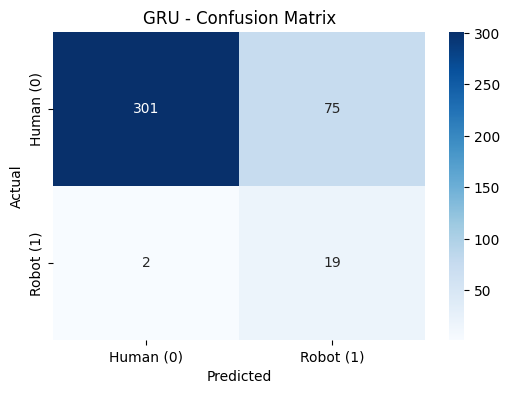

In [81]:
# GRU - Compute and plot confusion matrix
cm_2 = confusion_matrix(y_val, y_pred_gru)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Human (0)', 'Robot (1)'],
            yticklabels=['Human (0)', 'Robot (1)'])
plt.title('GRU - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

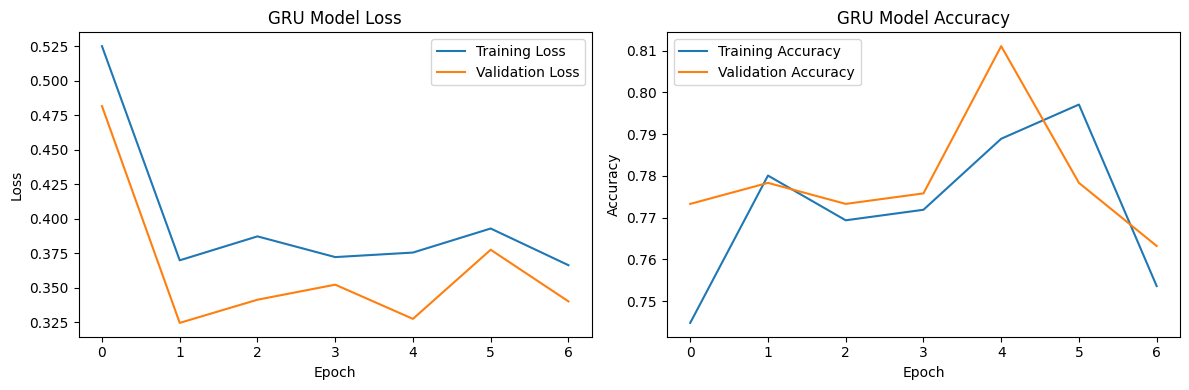

In [82]:
# Optional: GRU - Plot training history (loss and accuracy)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['accuracy'], label='Training Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [83]:
# Make predictions
y_train_pred_prob_gru = gru_model.predict(X_train)
y_val_pred_prob_gru = gru_model.predict(X_val)
y_train_pred_gru = (y_train_pred_prob_gru > 0.5).astype(int).flatten()
y_val_pred_gru = (y_val_pred_prob_gru > 0.5).astype(int).flatten()

# Compute evaluation metrics for training and test sets
metrics_gru = {
    'AUC-ROC': [roc_auc_score(y_train, y_train_pred_prob_gru), roc_auc_score(y_val, y_val_pred_prob_gru)],
    'Precision': [precision_score(y_train, y_train_pred_gru), precision_score(y_val, y_val_pred_gru)],
    'Recall': [recall_score(y_train, y_train_pred_gru), recall_score(y_val, y_val_pred_gru)],
    'F1-Score': [f1_score(y_train, y_train_pred_gru), f1_score(y_val, y_val_pred_gru)]
}

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


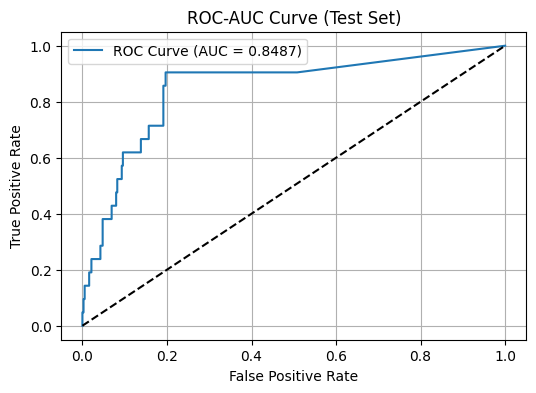

In [84]:
from sklearn.metrics import roc_curve, precision_recall_curve


# Plot ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_prob_gru)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics_gru["AUC-ROC"][1]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC-AUC Curve (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('findings/gru_roc_auc_curve.png')
plt.show()
plt.close()

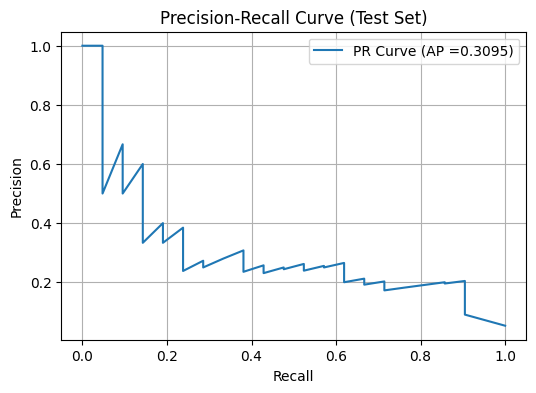

In [85]:
from sklearn.metrics import average_precision_score

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_val_pred_prob_gru)
ap_score = average_precision_score(y_val, y_val_pred_prob_gru)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR Curve (AP ={ap_score:.4f})')
plt.title('Precision-Recall Curve (Test Set)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.savefig('findings/gru_precision_recall_curve.png')
plt.show()
plt.close()

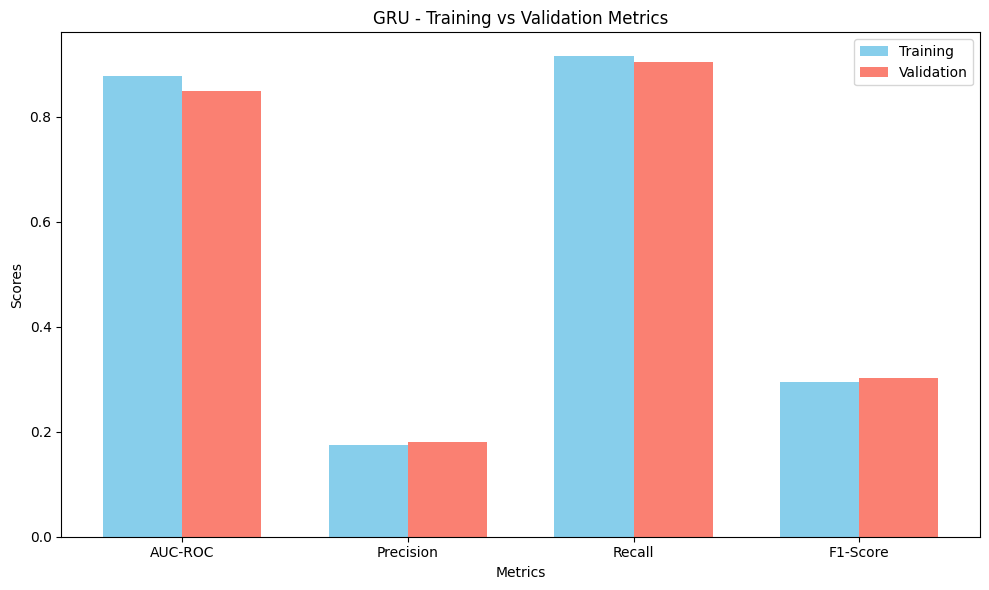

In [86]:
# Plot training vs validation bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics_gru))

ax.bar(index, [metrics_gru[m][0] for m in metrics_gru], bar_width, label='Training', color='skyblue')
ax.bar(index + bar_width, [metrics_gru[m][1] for m in metrics_gru], bar_width, label='Validation', color='salmon')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('GRU - Training vs Validation Metrics')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics_gru.keys())
ax.legend()
plt.tight_layout()
plt.savefig('findings/gru_training_vs_validation_metrics.png')
plt.show()
plt.close()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Threshold: 0.50, Precision: 0.181, Recall: 0.905, F1: 0.302
Threshold: 0.55, Precision: 0.194, Recall: 0.905, F1: 0.319
Threshold: 0.60, Precision: 0.202, Recall: 0.905, F1: 0.330
Threshold: 0.65, Precision: 0.203, Recall: 0.714, F1: 0.316
Threshold: 0.70, Precision: 0.250, Recall: 0.429, F1: 0.316
Threshold: 0.75, Precision: 0.312, Recall: 0.238, F1: 0.270
Threshold: 0.80, Precision: 0.333, Recall: 0.143, F1: 0.200
Threshold: 0.85, Precision: 0.600, Recall: 0.143, F1: 0.231


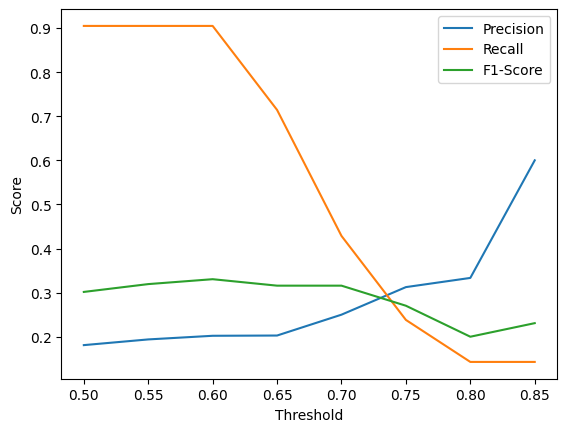

Optimal Threshold: 0.60
Final Precision: 0.202
Final Recall: 0.905
Final F1-Score: 0.330


In [87]:
# Get predicted probabilities
y_pred_proba = gru_model.predict(X_val)

# Evaluate different thresholds
thresholds = np.arange(0.5, 0.9, 0.05)
precisions, recalls, f1_scores = [], [], []
for thresh in thresholds:
    y_pred = (y_pred_proba > thresh).astype(int)
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))
    print(f"Threshold: {thresh:.2f}, Precision: {precisions[-1]:.3f}, Recall: {recalls[-1]:.3f}, F1: {f1_scores[-1]:.3f}")

# Plot precision-recall trade-off
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# Choose optimal threshold (e.g., maximizing F1 or precision with acceptable recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]  # Or manually select based on precision-recall balance
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Final Precision: {precision_score(y_val, y_pred_optimal):.3f}")
print(f"Final Recall: {recall_score(y_val, y_pred_optimal):.3f}")
print(f"Final F1-Score: {f1_score(y_val, y_pred_optimal):.3f}")

In [88]:
# Save model
gru_model.save("models/gru_model.keras")

### Testing on GRU model

In [98]:
X_test = np.load('datasets/X_test.npy')
X_test.shape

(4630, 100, 9)

In [99]:
# GRU - Make predictions
y_pred_prob_gru = gru_model.predict(X_test)
y_pred_gru = (y_pred_prob_gru > 0.6).astype(int).flatten()

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [100]:
y_pred_gru.shape

(4630,)

In [101]:
y_pred_series = pd.Series(y_pred_prob_gru.reshape(-1), name='prediction') 
y_pred_series

0       0.003657
1       0.003657
2       0.003657
3       0.003683
4       0.663750
          ...   
4625    0.003657
4626    0.731851
4627    0.655890
4628    0.003657
4629    0.648877
Name: prediction, Length: 4630, dtype: float32

In [102]:
bidder_ids = np.load('datasets/bidders_ids.npy')
df = pd.DataFrame(bidder_ids, columns=['bidder_id'])
df['prediction'] = y_pred_series

In [103]:
print(df.shape)
df.head()

(4630, 2)


,bidder_id,prediction
0,002d229ffb247009810828f648afc2ef593rb,0.003657
1,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.003657
2,00486a11dff552c4bd7696265724ff81yeo9v,0.003657
3,0051aef3fdeacdadba664b9b3b07e04e4coc6,0.003683
4,0053b78cde37c4384a20d2da9aa4272aym4pb,0.663750


In [104]:
# bidder ids with missing columns -- assumes to be human
na_bidders = pd.read_csv('datasets/bidder_ids_na.csv')
na_bidders['prediction'] = 0.0

print(na_bidders.shape)
na_bidders.head()

(70, 2)


,bidder_id,prediction
0,b24e3af20453813e821f5a22ff55e072tgton,0.0
1,65489e2734f03652a76bf139df96c479lopnf,0.0
2,3c465a8c5b93301383617e4c539c850aumt08,0.0
3,55a699bd3a83fe99db348c4302ee754ep392w,0.0
4,4b24254e994ad8abcc4b5b4020991960q7j30,0.0


In [105]:
# Merge vertically
merged_df = pd.concat([df, na_bidders], axis=0)
print(merged_df.shape)
merged_df.head()

(4700, 2)


,bidder_id,prediction
0,002d229ffb247009810828f648afc2ef593rb,0.003657
1,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.003657
2,00486a11dff552c4bd7696265724ff81yeo9v,0.003657
3,0051aef3fdeacdadba664b9b3b07e04e4coc6,0.003683
4,0053b78cde37c4384a20d2da9aa4272aym4pb,0.663750


In [106]:
# Output 2: GRU prediction
merged_df.to_csv('result/gru_submission.csv', index=False)